```
Path global_path: 
    HelperLatLon[] waypoints: HelperLatLon: 
        float32 latitude 
        float32 longitude 

Path local_path: 
    HelperLatLon[] waypoints: 
        HelperLatLon: 
            float32 latitude 
            float32 longitude 

GPS gps: 
    HelperLatLon lat_lon: 
        float32 latitude 
        float32 longitude 
    HelperSpeed speed: 
        float32 speed 
    HelperHeading heading: 
        float32 heading 

WindSensor filtered_wind_sensor: 
    HelperSpeed speed: 
        float32 speed 
    int16 direction 

AISShips ais_ships: 
    HelperAISShip[] ships: 
        HelperAISShip:
            uint32 id 
            HelperLatLon lat_lon: 
                float32 latitude 
                float32 longitude 
            HelperHeading cog: 
                float32 heading 
            HelperSpeed sog: 
                float32 speed 
            HelperROT rot: 
                int8 rot 
            HelperDimension width: 
                float32 dimension 
            HelperDimension length: 
                float32 dimension 

HelperObstacle[] obstacles: 
    HelperObstacle: 
        HelperLatLon[] points 
            HelperLatLon: 
                float32 latitude 
                float32 longitude 
        string obstacle_type 

DesiredHeading desired_heading: 
    HelperHeading heading: 
        float32 heading 
        uint8 steering
```

In [ ]:
import pandas as pd
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

import local_pathfinding.coord_systems as cs
import local_pathfinding.wind_coord_systems as wcs

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# every SAMPLE_RATE'th datapoint will actually be drawn on the plot
SAMPLE_RATE = 6

In [15]:
bag_path = "/workspaces/sailbot_workspace/notebooks/local_pathfinding/session_recordings/datarecording_2026_02_22-22_43_25/datarecording_2026_02_22-22_43_25_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"


reader = rosbag2_py.SequentialReader()
storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
converter_options = rosbag2_py.ConverterOptions(
    input_serialization_format="cdr", output_serialization_format="cdr"
)

reader.open(storage_options, converter_options)
msg_class = get_message(msg_type)

rows = []

while reader.has_next():
    topic, data, t = reader.read_next()
    if topic != topic_name:
        continue

    msg = deserialize_message(data, msg_class)

    rows.append(
        {
            "timestamp": t,
            "global_path": msg.global_path,
            "local_path": msg.local_path,
            "gps": msg.gps,
            "filtered_wind_sensor": msg.filtered_wind_sensor,
            "ais_ships": msg.ais_ships,
            "obstacles": msg.obstacles,
            "desired_heading": msg.desired_heading,
        }
    )

df = pd.DataFrame(rows)

[INFO] [1771831374.352941532] [rosbag2_storage:228]: Opened database '/workspaces/sailbot_workspace/notebooks/local_pathfinding/session_recordings/datarecording_2026_02_22-22_43_25/datarecording_2026_02_22-22_43_25_0.db3' for READ_ONLY.


In [16]:
df.head()

,timestamp,global_path,local_path,gps,filtered_wind_sensor,ais_ships,obstacles,desired_heading
0,1771829014051688589,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
1,1771829015916513597,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
2,1771829017904878992,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
3,1771829020948967738,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
4,1771829038890590381,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...


In [23]:
# Displays the first 5 datapoints recorded by rosbag during the session.

import pandas as pd
from rosidl_runtime_py.convert import message_to_ordereddict


def as_py(obj):
    if obj is None:
        return None
    if isinstance(obj, (dict, list)):
        return obj
    try:
        return message_to_ordereddict(obj)
    except Exception:
        return obj


def extract_numeric(
    obj,
    preferred=(
        "heading",
        "desired_heading",
        "value",
        "deg",
        "degrees",
        "rad",
        "radians",
        "speed",
        "direction",
    ),
):
    d = as_py(obj)
    if isinstance(d, dict):
        for k in preferred:
            if k in d and isinstance(d[k], (int, float)):
                return float(d[k])
        for _, v in d.items():
            if isinstance(v, (int, float)):
                return float(v)
    return None


def extract_desired_heading(desired_heading_msg):
    """
    DesiredHeading dict looks like:
    OrderedDict([
      ('heading', OrderedDict([('heading', <float>)])),
      ('steering', 0)
    ])
    We want the nested heading value, not steering.
    """
    d = as_py(desired_heading_msg)
    if isinstance(d, dict):
        h = d.get("heading")
        if isinstance(h, dict) and "heading" in h and isinstance(h["heading"], (int, float)):
            return float(h["heading"])
    return None


def count_list(obj, candidates=("ships", "targets", "vessels", "obstacles", "items", "objects")):
    d = as_py(obj)
    if isinstance(d, list):
        return len(d)
    if isinstance(d, dict):
        for k in candidates:
            if k in d and isinstance(d[k], list):
                return len(d[k])
    return 0


def path_summary(path_msg):
    d = as_py(path_msg)
    if not isinstance(d, dict):
        return (0, None, None)
    wps = d.get("waypoints", [])
    if not isinstance(wps, list):
        return (0, None, None)

    def latlon(wp):
        wp = as_py(wp)
        if not isinstance(wp, dict):
            return None
        # waypoint may store lat/lon directly or nested in lat_lon
        if "latitude" in wp and "longitude" in wp:
            return (wp["latitude"], wp["longitude"])
        ll = wp.get("lat_lon")
        if isinstance(ll, dict) and "latitude" in ll and "longitude" in ll:
            return (ll["latitude"], ll["longitude"])
        return None

    n = len(wps)
    first = latlon(wps[0]) if n else None
    last = latlon(wps[-1]) if n else None
    return (n, first, last)


def summarize_row(row):
    # GPS/wind might be empty/default in "production only local_path" mode
    gps = row.get("gps", None)
    wind = row.get("filtered_wind_sensor", None)

    gps_lat = gps_lon = gps_hdg = gps_spd = None
    if gps is not None:
        try:
            gps_lat = float(gps.lat_lon.latitude)
            gps_lon = float(gps.lat_lon.longitude)
            gps_hdg = float(gps.heading.heading)
            gps_spd = float(gps.speed.speed)
        except Exception:
            pass

    wind_dir = wind_spd = None
    if wind is not None:
        try:
            wind_dir = float(wind.direction)
            wind_spd = float(wind.speed.speed)
        except Exception:
            pass

    lp_n, lp_first, lp_last = path_summary(row.get("local_path"))
    gp_n, gp_first, gp_last = path_summary(row.get("global_path"))

    desired_heading_val = extract_desired_heading(row.get("desired_heading"))
    steering_val = extract_numeric(row.get("desired_heading"), preferred=("steering",))

    return pd.Series(
        {
            "timestamp": row["timestamp"],
            # global_path
            "global_wp_n": gp_n,  # # of waypoints in global path
            "global_first": gp_first,  # first waypoint in global path (lat, lon)
            "global_last": gp_last,  # last waypoint in global path (lat, lon)
            # local_path
            "local_wp_n": lp_n,  # # of waypoints in local path
            "local_first": lp_first,  # first waypoint in local path (lat, lon)
            "local_last": lp_last,  # last waypoint in local path (lat, lon)
            # gps
            "gps_lat": gps_lat,
            "gps_lon": gps_lon,
            "gps_heading_deg": gps_hdg,
            "gps_speed": gps_spd,
            # filtered_wind_sensor
            "wind_dir_deg": wind_dir,
            "wind_speed": wind_spd,
            # ais_ships + obstacles
            "ais_ship_n": count_list(
                row.get("ais_ships"), candidates=("ships", "targets", "vessels")
            ),
            "obstacle_n": count_list(
                row.get("obstacles"), candidates=("obstacles", "items", "objects")
            ),
            # desired_heading (nested heading) + steering
            "desired_heading": desired_heading_val,
            "steering": steering_val,
        }
    )


df_summary = df.head(5).apply(summarize_row, axis=1)
df_summary

,timestamp,global_wp_n,global_first,global_last,local_wp_n,local_first,local_last,gps_lat,gps_lon,gps_heading_deg,gps_speed,wind_dir_deg,wind_speed,ais_ship_n,obstacle_n,desired_heading,steering
0,1771829014051688589,52,"(48.158390045166016, -130.25390625)","(49.270267486572266, -123.58733367919922)",4,"(49.279998779296875, -123.18506622314453)","(49.270267486572266, -123.58733367919922)",49.279999,-123.185066,-90.000000,3.243243,0.0,13.243243,5,6,27.706957,0.0
1,1771829015916513597,52,"(48.158390045166016, -130.25390625)","(49.270267486572266, -123.58733367919922)",3,"(49.28001022338867, -123.18507385253906)","(49.270267486572266, -123.58733367919922)",49.280010,-123.185074,27.706957,5.266541,-86.0,8.874848,5,6,-73.494934,0.0
2,1771829017904878992,52,"(48.158390045166016, -130.25390625)","(49.270267486572266, -123.58733367919922)",3,"(49.28001022338867, -123.18507385253906)","(49.270267486572266, -123.58733367919922)",49.280025,-123.185074,-73.494934,3.441502,-12.0,13.335585,5,6,-73.521324,0.0
3,1771829020948967738,52,"(48.158390045166016, -130.25390625)","(49.270267486572266, -123.58733367919922)",3,"(49.28001022338867, -123.18507385253906)","(49.270267486572266, -123.58733367919922)",49.280029,-123.185104,-73.521324,3.441185,-12.0,13.335612,5,6,-73.517723,0.0
4,1771829038890590381,52,"(48.158390045166016, -130.25390625)","(49.270267486572266, -123.58733367919922)",3,"(49.28001022338867, -123.18507385253906)","(49.270267486572266, -123.58733367919922)",49.280029,-123.185104,-73.521324,3.441185,-12.0,13.335612,5,6,-73.517723,0.0


In [ ]:
# position over time
positions_lat_lon = []
headings_deg = []
for data_point in df["gps"]:
    positions_lat_lon.append(data_point.lat_lon)
    headings_deg.append(data_point.heading.heading)

reference_point = positions_lat_lon[0]
positions_xy_km = cs.latlon_list_to_xy_list(reference_point, positions_lat_lon)

headings_cartesian_deg = [90 - heading_deg for heading_deg in headings_deg]
x_km = [xy.x for xy in positions_xy_km]
y_km = [xy.y for xy in positions_xy_km]

# Use every 3rd data point
x_km_sparse = x_km[::SAMPLE_RATE]
y_km_sparse = y_km[::SAMPLE_RATE]
headings_sparse = headings_cartesian_deg[::SAMPLE_RATE]

plt.scatter(x_km_sparse, y_km_sparse, s=20, label="Position")

# Add arrows for heading direction
# Convert headings to radians
heading_rads = np.radians(headings_sparse)

# Calculate arrow components
dx = np.cos(heading_rads)
dy = np.sin(heading_rads)

# Plot arrows with quiver (auto-scales nicely)
plt.quiver(
    x_km_sparse,
    y_km_sparse,
    dx,
    dy,
    color="red",
    scale=20,
    width=0.003,
    headwidth=3,
    headlength=4,
    label="Boat Heading",
)

# get the true wind directions
boat_headings_deg = []
boat_speeds_kmph = []
for data_point in df["gps"]:
    boat_headings_deg.append(data_point.heading.heading)
    boat_speeds_kmph.append(data_point.speed.speed)

aw_directions_deg = []
aw_speeds_kmph = []
for data_point in df["filtered_wind_sensor"]:
    aw_directions_deg.append(data_point.direction)
    aw_speeds_kmph.append(data_point.speed.speed)

aw_directions_degrees_global_coords = [
    wcs.boat_to_global_coordinate(boat_hding_deg, aw_dir_deg)
    for boat_hding_deg, aw_dir_deg in zip(boat_headings_deg, aw_directions_deg)
]

tw_directions_rad, tw_speeds_kmph = zip(
    *[
        wcs.get_true_wind(
            aw_dir_deg_global_coords,
            aw_speed_kmph,
            boat_hding_deg,
            boat_speed_kmph,
        )
        for aw_dir_deg_global_coords, aw_speed_kmph, boat_hding_deg, boat_speed_kmph in zip(
            aw_directions_degrees_global_coords,
            aw_speeds_kmph,
            boat_headings_deg,
            boat_speeds_kmph,
        )
    ]
)

tw_directions_deg_cartesian = [90 - np.degrees(a) for a in tw_directions_rad][::SAMPLE_RATE]

# Add arrows for true wind direction
# Convert headings to radians
heading_rads = np.radians([tw_directions_deg_cartesian[i] for i in range(len(x_km_sparse))])

# Calculate arrow components
dx = np.cos(heading_rads)
dy = np.sin(heading_rads)

# Plot arrows with quiver (auto-scales nicely)
plt.quiver(
    x_km_sparse,
    y_km_sparse,
    dx,
    dy,
    color="green",
    scale=20,
    width=0.003,
    headwidth=3,
    headlength=4,
    label="True Wind Direction",
)

plt.title("Sailbot Position & Heading vs. Time\n(Start Used as Reference)")
plt.xlabel("X (Km)")
plt.ylabel("Y (Km)")
plt.grid(visible=True)
plt.axis("equal")
plt.legend()
plt.show()

NameError: name 'cs' is not defined

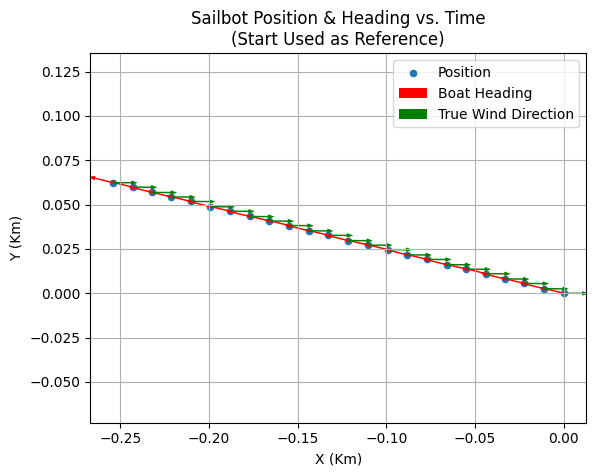

In [6]:
# position over time
positions_lat_lon = []
headings_deg = []
for data_point in df["gps"]:
    positions_lat_lon.append(data_point.lat_lon)
    headings_deg.append(data_point.heading.heading)

reference_point = positions_lat_lon[0]
positions_xy_km = cs.latlon_list_to_xy_list(reference_point, positions_lat_lon)

headings_cartesian_deg = [90 - heading_deg for heading_deg in headings_deg]
x_km = [xy.x for xy in positions_xy_km]
y_km = [xy.y for xy in positions_xy_km]

# Use every 3rd data point
x_km_sparse = x_km[::SAMPLE_RATE]
y_km_sparse = y_km[::SAMPLE_RATE]
headings_sparse = headings_cartesian_deg[::SAMPLE_RATE]

plt.scatter(x_km_sparse, y_km_sparse, s=20, label="Position")

# Add arrows for heading direction
# Convert headings to radians
heading_rads = np.radians(headings_sparse)

# Calculate arrow components
dx = np.cos(heading_rads)
dy = np.sin(heading_rads)

# Plot arrows with quiver (auto-scales nicely)
plt.quiver(
    x_km_sparse,
    y_km_sparse,
    dx,
    dy,
    color="red",
    scale=20,
    width=0.003,
    headwidth=3,
    headlength=4,
    label="Boat Heading",
)

# get the true wind directions
boat_headings_deg = []
boat_speeds_kmph = []
for data_point in df["gps"]:
    boat_headings_deg.append(data_point.heading.heading)
    boat_speeds_kmph.append(data_point.speed.speed)

aw_directions_deg = []
aw_speeds_kmph = []
for data_point in df["filtered_wind_sensor"]:
    aw_directions_deg.append(data_point.direction)
    aw_speeds_kmph.append(data_point.speed.speed)

aw_directions_degrees_global_coords = [
    wcs.boat_to_global_coordinate(boat_hding_deg, aw_dir_deg)
    for boat_hding_deg, aw_dir_deg in zip(boat_headings_deg, aw_directions_deg)
]

tw_directions_rad, tw_speeds_kmph = zip(
    *[
        wcs.get_true_wind(
            aw_dir_deg_global_coords,
            aw_speed_kmph,
            boat_hding_deg,
            boat_speed_kmph,
        )
        for aw_dir_deg_global_coords, aw_speed_kmph, boat_hding_deg, boat_speed_kmph in zip(
            aw_directions_degrees_global_coords,
            aw_speeds_kmph,
            boat_headings_deg,
            boat_speeds_kmph,
        )
    ]
)

tw_directions_deg_cartesian = [90 - np.degrees(a) for a in tw_directions_rad][::SAMPLE_RATE]

# Add arrows for true wind direction
# Convert headings to radians
heading_rads = np.radians([tw_directions_deg_cartesian[i] for i in range(len(x_km_sparse))])

# Calculate arrow components
dx = np.cos(heading_rads)
dy = np.sin(heading_rads)

# Plot arrows with quiver (auto-scales nicely)
plt.quiver(
    x_km_sparse,
    y_km_sparse,
    dx,
    dy,
    color="green",
    scale=20,
    width=0.003,
    headwidth=3,
    headlength=4,
    label="True Wind Direction",
)

plt.title("Sailbot Position & Heading vs. Time\n(Start Used as Reference)")
plt.xlabel("X (Km)")
plt.ylabel("Y (Km)")
plt.grid(visible=True)
plt.axis("equal")
plt.legend()
plt.show()

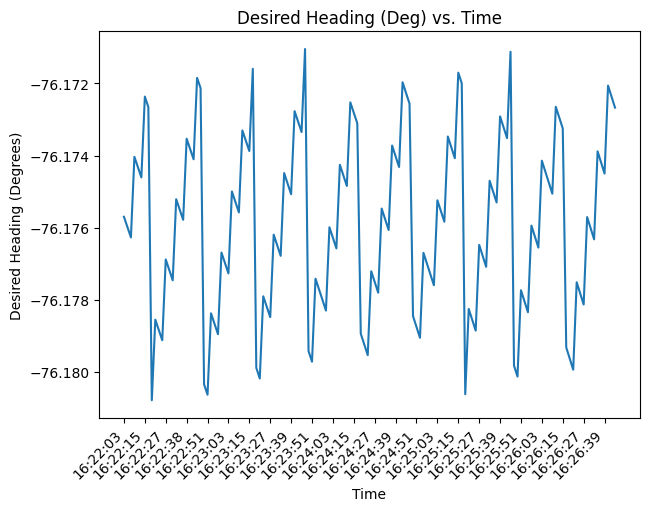

In [7]:
# desired heading vs time
time = [t for t in df["timestamp"]]
timestamps = [datetime.fromtimestamp(t / 1_000_000_000).strftime("%H:%M:%S") for t in time]
d_headings_deg = [data_point.heading.heading for data_point in df["desired_heading"]]

plt.plot(timestamps, d_headings_deg)

# Show only every 3rd timestamp label at an angle
plt.xticks(
    range(0, len(timestamps), SAMPLE_RATE),
    [timestamps[i] for i in range(0, len(timestamps), SAMPLE_RATE)],
    rotation=45,
    ha="right",
)

plt.tight_layout()
plt.title("Desired Heading (Deg) vs. Time")
plt.ylabel("Desired Heading (Degrees)")
plt.xlabel("Time")
plt.show()

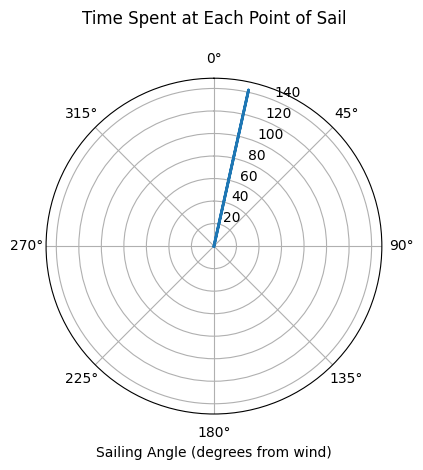

In [8]:
# Sailing Angle Distribution
boat_headings_deg = []
boat_speeds_kmph = []
for data_point in df["gps"]:
    boat_headings_deg.append(data_point.heading.heading)
    boat_speeds_kmph.append(data_point.speed.speed)

aw_directions_deg = []
aw_speeds_kmph = []
for data_point in df["filtered_wind_sensor"]:
    aw_directions_deg.append(data_point.direction)
    aw_speeds_kmph.append(data_point.speed.speed)

aw_directions_degrees_global_coords = [
    wcs.boat_to_global_coordinate(boat_hding_deg, aw_dir_deg)
    for boat_hding_deg, aw_dir_deg in zip(boat_headings_deg, aw_directions_deg)
]

tw_directions_rad, tw_speeds_kmph = zip(
    *[
        wcs.get_true_wind(
            aw_dir_deg_global_coords,
            aw_speed_kmph,
            boat_hding_deg,
            boat_speed_kmph,
        )
        for aw_dir_deg_global_coords, aw_speed_kmph, boat_hding_deg, boat_speed_kmph in zip(
            aw_directions_degrees_global_coords,
            aw_speeds_kmph,
            boat_headings_deg,
            boat_speeds_kmph,
        )
    ]
)

tw_directions_deg = [np.degrees(a) for a in tw_directions_rad]
sailing_angles_deg = [
    abs(-tw_dir - boat_hding) for tw_dir, boat_hding in zip(tw_directions_deg, boat_headings_deg)
]

# Create histogram bins
num_bins = 36  # 5-degree bins for 180 degrees
counts, bin_edges = np.histogram(sailing_angles_deg, bins=num_bins, range=(0, 180))

# Convert bin edges to radians for polar plot
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
theta = np.radians(bin_centers)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

# Plot as continuous curve
# Close the curve by appending first value
theta_closed = np.append(theta, theta[0])
counts_closed = np.append(counts, counts[0])

ax.plot(theta_closed, counts_closed, linewidth=2)
ax.fill(theta_closed, counts_closed, alpha=0.3)

# Set 0 degrees at top
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)  # Clockwise

# Labels
ax.set_title("Time Spent at Each Point of Sail", pad=20)
ax.set_xlabel("Sailing Angle (degrees from wind)")

plt.tight_layout()
plt.show()

In [ ]:
# Calculates number of cycles vs. number of switches

import numpy as np
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message


bag_path = "/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"

# How aggressively to consider a "switch"
ROUND_DECIMALS = 3
POINT_STRIDE = 1


def _is_sequence(x):
    return hasattr(x, "__len__") and not isinstance(x, (str, bytes, bytearray))


def _try_extract_xy(pt):
    # PoseStamped / Pose: pt.pose.position.x
    if hasattr(pt, "pose") and hasattr(pt.pose, "position"):
        p = pt.pose.position
        if hasattr(p, "x") and hasattr(p, "y"):
            return float(p.x), float(p.y)

    # Pose: pt.position.x
    if hasattr(pt, "position") and hasattr(pt.position, "x") and hasattr(pt.position, "y"):
        p = pt.position
        return float(p.x), float(p.y)

    # Point-like: pt.x, pt.y
    if hasattr(pt, "x") and hasattr(pt, "y"):
        return float(pt.x), float(pt.y)

    # If your local path is lat/lon points
    if hasattr(pt, "lat") and hasattr(pt, "lon"):
        return float(pt.lat), float(pt.lon)

    return None


def _flatten_scalars(obj, out, depth=0, max_depth=6):
    if depth > max_depth or obj is None:
        return

    if isinstance(obj, (bool, int, float, np.number)):
        out.append(float(obj))
        return

    if _is_sequence(obj):
        for v in obj:
            _flatten_scalars(v, out, depth + 1, max_depth)
        return

    if hasattr(obj, "__slots__"):
        for slot in obj.__slots__:
            try:
                v = getattr(obj, slot)
            except Exception:
                continue
            _flatten_scalars(v, out, depth + 1, max_depth)
        return


def path_signature(local_path):
    pts = None

    if hasattr(local_path, "poses"):
        pts = local_path.poses
    elif hasattr(local_path, "points"):
        pts = local_path.points
    elif _is_sequence(local_path):
        pts = local_path

    if pts is not None and _is_sequence(pts) and len(pts) > 0:
        xy = []
        for p in pts[::POINT_STRIDE]:
            got = _try_extract_xy(p)
            if got is None:
                scalars = []
                _flatten_scalars(p, scalars)
                if len(scalars) >= 2:
                    got = (scalars[0], scalars[1])

            if got is not None:
                x, y = got
                xy.append((round(x, ROUND_DECIMALS), round(y, ROUND_DECIMALS)))

        if len(xy) > 0:
            return ("xy", tuple(xy))

    scalars = []
    _flatten_scalars(local_path, scalars)
    scalars = [round(v, ROUND_DECIMALS) for v in scalars]
    return ("flat", tuple(scalars))


def compute_switch_stats_per_cycle():
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions("cdr", "cdr")
    reader.open(storage_options, converter_options)

    msg_class = get_message(msg_type)

    num_cycles = 0
    num_switches = 0
    prev_sig = None

    while reader.has_next():
        topic, data, t = reader.read_next()
        if topic != topic_name:
            continue

        msg = deserialize_message(data, msg_class)
        sig = path_signature(msg.local_path)

        if prev_sig is not None and sig != prev_sig:
            num_switches += 1

        prev_sig = sig
        num_cycles += 1

    ratio_per_cycle = (num_switches / num_cycles) if num_cycles > 0 else float("nan")

    return {
        "num_cycles": num_cycles,
        "num_switches": num_switches,
        "ratio_switches_per_cycle": ratio_per_cycle,
    }


stats = compute_switch_stats_per_cycle()
print(stats)

[INFO] [1770440936.457363621] [rosbag2_storage:228]: Opened database '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' for READ_ONLY.


{'num_cycles': 142, 'num_switches': 0, 'ratio_switches_per_cycle': 0.0}


In [ ]:
# Calculates number of cycles vs. number of desired heading changes

import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message


bag_path = "/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"

# Degrees. Changes <= this are treated as "no change" (noise/jitter).
HEADING_CHANGE_TOL_DEG = 1.0


def ang_diff_deg(a_deg: float, b_deg: float) -> float:
    """
    Smallest absolute difference between two headings in degrees, in [0, 180].
    Handles wrap-around (e.g., 359 vs 1 -> 2 deg).
    """
    a = a_deg % 360.0
    b = b_deg % 360.0
    d = (a - b + 180.0) % 360.0 - 180.0  # in [-180, 180)
    return abs(d)


def compute_desired_heading_change_stats_per_cycle():
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions("cdr", "cdr")
    reader.open(storage_options, converter_options)

    msg_class = get_message(msg_type)

    num_cycles = 0
    num_heading_changes = 0
    prev_heading = None

    while reader.has_next():
        topic, data, t = reader.read_next()
        if topic != topic_name:
            continue

        msg = deserialize_message(data, msg_class)

        # Adjust this line if your desired heading field differs
        heading_deg = float(msg.desired_heading.heading.heading)

        if prev_heading is not None:
            if ang_diff_deg(heading_deg, prev_heading) > HEADING_CHANGE_TOL_DEG:
                num_heading_changes += 1

        prev_heading = heading_deg
        num_cycles += 1

    ratio_per_cycle = (num_heading_changes / num_cycles) if num_cycles > 0 else float("nan")

    return {
        "num_cycles": num_cycles,
        "num_heading_changes": num_heading_changes,
        "heading_change_tol_deg": HEADING_CHANGE_TOL_DEG,
        "ratio_changes_per_cycle": ratio_per_cycle,
    }


stats = compute_desired_heading_change_stats_per_cycle()
print(stats)

[ERROR] [1770441418.755497719] [rosbag2_storage:134]: Could not open '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' with 'sqlite3'. Error: Failed to read from bag: File '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' does not exist!
[ERROR] [1770441418.755609200] [rosbag2_storage:198]: Could not load/open plugin with storage id 'sqlite3'


RuntimeError: No storage could be initialized from the inputs.

In [ ]:
# Calculates actual distance travelled vs. straight-line distance

import numpy as np
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

# --- CONFIG ---
bag_path = "/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"

# If you already have this in your notebook, keep using it.
# It must provide: cs.latlon_list_to_xy_list(reference_point, latlon_list) -> list of objects with .x, .y
# from your_pkg import cs


def get_lat_lon(latlon_obj):
    """
    Tries common representations:
      - latlon_obj.lat, latlon_obj.lon
      - latlon_obj.latitude, latlon_obj.longitude
      - latlon_obj[0], latlon_obj[1] (tuple/list)
    Returns (lat, lon) as floats.
    """
    if hasattr(latlon_obj, "lat") and hasattr(latlon_obj, "lon"):
        return float(latlon_obj.lat), float(latlon_obj.lon)
    if hasattr(latlon_obj, "latitude") and hasattr(latlon_obj, "longitude"):
        return float(latlon_obj.latitude), float(latlon_obj.longitude)
    if isinstance(latlon_obj, (list, tuple)) and len(latlon_obj) >= 2:
        return float(latlon_obj[0]), float(latlon_obj[1])
    raise AttributeError(f"Unrecognized lat/lon object shape: {type(latlon_obj)}")


def haversine_m(lat1, lon1, lat2, lon2):
    """Great-circle distance in meters (fallback if you don't want cs conversion)."""
    R = 6371000.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(p1) * np.cos(p2) * np.sin(dlmb / 2) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


def compute_distance_ratio_from_bag(use_cs_xy=True):
    """
    Computes:
      - distance_travelled: sum of segment lengths
      - straight_line: start->end distance
      - ratio = travelled / straight_line
    """
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions("cdr", "cdr")
    reader.open(storage_options, converter_options)

    msg_class = get_message(msg_type)

    latlons = []

    while reader.has_next():
        topic, data, t = reader.read_next()
        if topic != topic_name:
            continue

        msg = deserialize_message(data, msg_class)

        # GPS object expected on each LPathData message
        gps = msg.gps
        ll = gps.lat_lon

        lat, lon = get_lat_lon(ll)
        latlons.append((lat, lon))

    if len(latlons) < 2:
        return {
            "num_points": len(latlons),
            "distance_travelled_m": float("nan"),
            "straight_line_m": float("nan"),
            "ratio": float("nan"),
            "note": "Need at least 2 GPS points.",
        }

    if use_cs_xy:
        # Use your local XY conversion (recommended if already validated)
        # Build a compatible latlon list for your cs function.
        # If cs expects objects, you can adapt this part accordingly.
        reference = latlons[0]
        # If your cs function expects a list of latlon objects rather than tuples,
        # set use_cs_xy=False and use haversine fallback, or adapt below.
        positions_xy = cs.latlon_list_to_xy_list(reference, latlons)  # <-- may need adapting

        x = np.array([p.x for p in positions_xy], dtype=float)
        y = np.array([p.y for p in positions_xy], dtype=float)

        seg = np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2)
        travelled = (
            float(seg.sum()) * 1000.0
        )  # if your cs outputs km; remove *1000 if already meters

        straight = float(np.sqrt((x[-1] - x[0]) ** 2 + (y[-1] - y[0]) ** 2)) * 1000.0
    else:
        # Pure GPS fallback: great-circle distances
        travelled = 0.0
        for (lat1, lon1), (lat2, lon2) in zip(latlons[:-1], latlons[1:]):
            travelled += haversine_m(lat1, lon1, lat2, lon2)

        lat1, lon1 = latlons[0]
        lat2, lon2 = latlons[-1]
        straight = haversine_m(lat1, lon1, lat2, lon2)

    ratio = travelled / straight if straight > 0 else float("nan")

    return {
        "num_points": len(latlons),
        "distance_travelled_m": travelled,
        "straight_line_m": straight,
        "ratio_travelled_over_straight": ratio,
    }


# --- RUN ---
# If you aren't sure cs.latlon_list_to_xy_list accepts tuples, set use_cs_xy=False.
stats = compute_distance_ratio_from_bag(use_cs_xy=False)
print(stats)

[ERROR] [1770441495.091555896] [rosbag2_storage:134]: Could not open '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' with 'sqlite3'. Error: Failed to read from bag: File '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' does not exist!
[ERROR] [1770441495.091630021] [rosbag2_storage:198]: Could not load/open plugin with storage id 'sqlite3'


RuntimeError: No storage could be initialized from the inputs.

In [ ]:
# Calculates travel time / (distance travelled by boat/average wind speed)

import numpy as np
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

# --- CONFIG ---
bag_path = "/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"

# If your wind speed is already m/s, set this to False
WIND_SPEED_IS_KMPH = True


def haversine_m(lat1, lon1, lat2, lon2):
    """Great-circle distance in meters."""
    R = 6371000.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(p1) * np.cos(p2) * np.sin(dlmb / 2) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


def get_lat_lon(latlon_obj):
    """
    Tries common representations:
      - latlon_obj.lat, latlon_obj.lon
      - latlon_obj.latitude, latlon_obj.longitude
      - tuple/list (lat, lon)
    """
    if hasattr(latlon_obj, "lat") and hasattr(latlon_obj, "lon"):
        return float(latlon_obj.lat), float(latlon_obj.lon)
    if hasattr(latlon_obj, "latitude") and hasattr(latlon_obj, "longitude"):
        return float(latlon_obj.latitude), float(latlon_obj.longitude)
    if isinstance(latlon_obj, (list, tuple)) and len(latlon_obj) >= 2:
        return float(latlon_obj[0]), float(latlon_obj[1])
    raise AttributeError(f"Unrecognized lat/lon object: {type(latlon_obj)}")


def compute_time_distance_wind_ratio():
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions("cdr", "cdr")
    reader.open(storage_options, converter_options)

    msg_class = get_message(msg_type)

    times_ns = []
    latlons = []
    wind_speeds = []

    while reader.has_next():
        topic, data, t = reader.read_next()
        if topic != topic_name:
            continue

        msg = deserialize_message(data, msg_class)

        # timestamps
        times_ns.append(int(t))

        # GPS lat/lon
        lat, lon = get_lat_lon(msg.gps.lat_lon)
        latlons.append((lat, lon))

        # Wind speed (filtered)
        # You used: data_point.speed.speed earlier, so match that
        ws = float(msg.filtered_wind_sensor.speed.speed)
        wind_speeds.append(ws)

    n = len(times_ns)
    if n < 2:
        return {
            "note": "Need at least 2 messages on the topic to compute travel time and distance.",
            "num_cycles": n,
        }

    # Travel time (seconds)
    t0, t1 = times_ns[0], times_ns[-1]
    travel_time_s = (t1 - t0) * 1e-9

    # Distance travelled (meters): sum of segment distances
    dist_m = 0.0
    for (lat1, lon1), (lat2, lon2) in zip(latlons[:-1], latlons[1:]):
        dist_m += haversine_m(lat1, lon1, lat2, lon2)

    # Mean wind speed (m/s)
    mean_wind = float(np.mean(wind_speeds)) if len(wind_speeds) else float("nan")
    if WIND_SPEED_IS_KMPH:
        mean_wind_mps = mean_wind * (1000.0 / 3600.0)
    else:
        mean_wind_mps = mean_wind

    # Expected time = distance / mean wind speed
    expected_time_s = (dist_m / mean_wind_mps) if mean_wind_mps > 0 else float("nan")

    ratio = (
        (travel_time_s / expected_time_s)
        if expected_time_s and expected_time_s > 0
        else float("nan")
    )
    # Equivalent: ratio = travel_time_s * mean_wind_mps / dist_m

    return {
        "num_cycles": n,
        "travel_time_s": travel_time_s,
        "distance_travelled_m": dist_m,
        "mean_wind_speed_input_units": mean_wind,
        "mean_wind_speed_mps": mean_wind_mps,
        "expected_time_s_(distance/mean_wind)": expected_time_s,
        "ratio_travel_time_over_expected": ratio,
    }


stats = compute_time_distance_wind_ratio()
print(stats)

[ERROR] [1770441495.386220180] [rosbag2_storage:134]: Could not open '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' with 'sqlite3'. Error: Failed to read from bag: File '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' does not exist!
[ERROR] [1770441495.386297670] [rosbag2_storage:198]: Could not load/open plugin with storage id 'sqlite3'


RuntimeError: No storage could be initialized from the inputs.

In [ ]:
# Calculates actual travel time vs. ideal travel time (2 metrics)

import numpy as np
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

# --- CONFIG ---
bag_path = "/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"

# Set these based on your message units
BOAT_SPEED_IS_KMPH = True  # msg.gps.speed.speed
WIND_SPEED_IS_KMPH = True  # msg.filtered_wind_sensor.speed.speed


def get_lat_lon(latlon_obj):
    if hasattr(latlon_obj, "lat") and hasattr(latlon_obj, "lon"):
        return float(latlon_obj.lat), float(latlon_obj.lon)
    if hasattr(latlon_obj, "latitude") and hasattr(latlon_obj, "longitude"):
        return float(latlon_obj.latitude), float(latlon_obj.longitude)
    if isinstance(latlon_obj, (list, tuple)) and len(latlon_obj) >= 2:
        return float(latlon_obj[0]), float(latlon_obj[1])
    raise AttributeError(f"Unrecognized lat/lon object: {type(latlon_obj)}")


def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(p1) * np.cos(p2) * np.sin(dlmb / 2) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


def kmph_to_mps(v):
    return v * (1000.0 / 3600.0)


def compute_actual_vs_ideal():
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions("cdr", "cdr")
    reader.open(storage_options, converter_options)

    msg_class = get_message(msg_type)

    times_ns = []
    latlons = []
    boat_speeds = []
    wind_speeds = []

    while reader.has_next():
        topic, data, t = reader.read_next()
        if topic != topic_name:
            continue

        msg = deserialize_message(data, msg_class)

        times_ns.append(int(t))

        lat, lon = get_lat_lon(msg.gps.lat_lon)
        latlons.append((lat, lon))

        boat_speeds.append(float(msg.gps.speed.speed))
        wind_speeds.append(float(msg.filtered_wind_sensor.speed.speed))

    n = len(times_ns)
    if n < 2:
        return {"note": "Need at least 2 messages to compute travel time.", "num_cycles": n}

    # Actual travel time
    actual_time_s = (times_ns[-1] - times_ns[0]) * 1e-9

    # Straight-line distance start->end
    lat1, lon1 = latlons[0]
    lat2, lon2 = latlons[-1]
    straight_m = haversine_m(lat1, lon1, lat2, lon2)

    # Convert speeds to m/s if needed
    boat_speeds_mps = (
        np.array([kmph_to_mps(v) for v in boat_speeds])
        if BOAT_SPEED_IS_KMPH
        else np.array(boat_speeds)
    )
    wind_speeds_mps = (
        np.array([kmph_to_mps(v) for v in wind_speeds])
        if WIND_SPEED_IS_KMPH
        else np.array(wind_speeds)
    )

    mean_wind_mps = float(np.mean(wind_speeds_mps))
    max_boat_mps = float(np.max(boat_speeds_mps))

    # Ideal time options
    ideal_time_wind_s = (straight_m / mean_wind_mps) if mean_wind_mps > 0 else float("nan")
    ideal_time_maxboat_s = (straight_m / max_boat_mps) if max_boat_mps > 0 else float("nan")

    ratio_wind = (
        (actual_time_s / ideal_time_wind_s)
        if ideal_time_wind_s and ideal_time_wind_s > 0
        else float("nan")
    )
    ratio_maxboat = (
        (actual_time_s / ideal_time_maxboat_s)
        if ideal_time_maxboat_s and ideal_time_maxboat_s > 0
        else float("nan")
    )

    return {
        "num_cycles": n,
        "actual_time_s": actual_time_s,
        "straight_line_distance_m": straight_m,
        "mean_wind_speed_mps": mean_wind_mps,
        "max_boat_speed_mps": max_boat_mps,
        "ideal_time_straight_over_mean_wind_s": ideal_time_wind_s,
        "ideal_time_straight_over_max_boat_s": ideal_time_maxboat_s,
        "ratio_actual_over_ideal_(wind_normalized)": ratio_wind,
        "ratio_actual_over_ideal_(max_boat_upper_bound)": ratio_maxboat,
    }


stats = compute_actual_vs_ideal()
print(stats)

[INFO] [1770440053.198721400] [rosbag2_storage:228]: Opened database '/workspaces/sailbot_workspace/notebooks/local_pathfinding/bags/bag1/bag1_0.db3' for READ_ONLY.


{'num_cycles': 142, 'actual_time_s': 282.30875618100004, 'straight_line_distance_m': 266.70328980628443, 'mean_wind_speed_mps': 3.7042913880892954, 'max_boat_speed_mps': 0.9470435645845202, 'ideal_time_straight_over_mean_wind_s': 71.99846390698012, 'ideal_time_straight_over_max_boat_s': 281.6167067491668, 'ratio_actual_over_ideal_(wind_normalized)': 3.921038600847576, 'ratio_actual_over_ideal_(max_boat_upper_bound)': 1.0024574161093704}
